# Variational Trajectory Autoencoder (2D Example)

In [1]:
%pylab inline
import seaborn as sns
from cycler import cycler
import torch
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
from sample_generator import make_demonstrations
from trajectory_vae import train, load_vtae, tensor_to_array
import warnings

sns.set()
warnings.simplefilter("ignore")

dpi = 72.27
textwidth = 5.78853
textheight = 8.2457

Populating the interactive namespace from numpy and matplotlib


We will generate a simple dataset of 2D trajectories.

In [2]:
X, _ = make_demonstrations(
    n_demonstrations=200, n_steps=200, goal=np.array([1., 2.]),
    random_state=0)
X = X.transpose(2, 0, 1)
n_task_dims, n_steps = X.shape[1:]

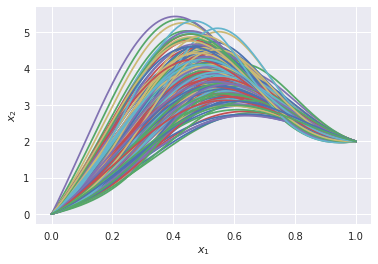

In [3]:
plt.figure()
plt.subplot(111)
plt.plot(X[:, 0].T, X[:, 1].T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

We will train a variational trajectory autoencoder on the dataset. The model will be saved in the file `simple.model`.

In [4]:
n_latent_dims = 2
dt = 0.01

In [5]:
train(X, dt, n_latent_dims, n_epochs=500, beta=0.1, batch_size=16, model_filename="simple.model", verbose=2)

Error: 73.967; Epochs: 100%|██████████| 500/500 [00:57<00:00,  8.63it/s]


In [6]:
model = load_vtae(n_latent_dims, n_task_dims, n_steps, dt, filename="simple.model")

## Grid

Now we can sample new parameters from a grid in latent space and project them to trajectory space.

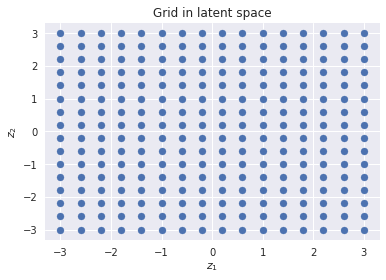

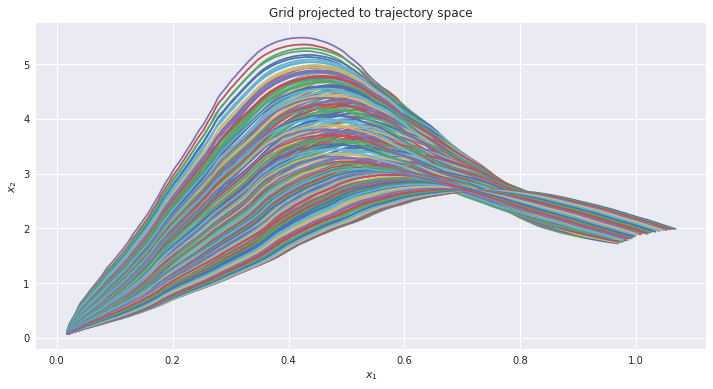

In [7]:
n_samples = 256
n_samples_dim = int(np.sqrt(n_samples))
max_value = 3.0
Z = np.vstack(map(np.ravel, np.meshgrid(np.linspace(-max_value, max_value, n_samples_dim),
                                        np.linspace(-max_value, max_value, n_samples_dim)))).T
Z = Variable(Tensor(Z))

X_reconstructed = model.decode(Z).detach().cpu().numpy()
samples = X_reconstructed.reshape(n_samples, n_task_dims, n_steps)

plt.figure()
plt.title("Grid in latent space")
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")

plt.figure(figsize=(12, 6))

plt.title("Grid projected to trajectory space")
plt.plot(samples[:, 0].T, samples[:, 1].T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.show()

## Axis

We can also sample latent variables along one axis in latent space and project them to parameter space. In this example each row of $W$ is an interpolation axis.

In [8]:
W = np.array([
    [0, 1],
    [1, 0]
])
feature_axes = [0, 1]

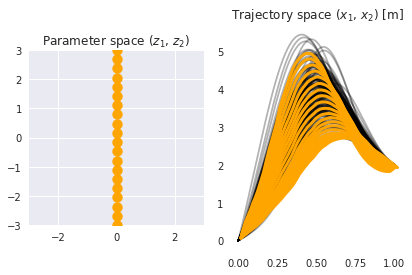

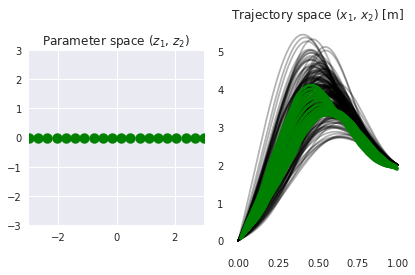

In [9]:
n_samples = 20
Z_test = np.zeros((2, n_samples, n_latent_dims))
X_test = np.zeros((2, n_samples, n_task_dims * n_steps))
for i, f in enumerate(feature_axes):
    Z_test[i] = np.array([
        np.array(W[f]) * np.linspace(-3, 3, n_samples)[j]
        for j in range(n_samples)
    ])
    X_test[i] = tensor_to_array(model.decode(Variable(Tensor(Z_test[i]))))

colors = ["orange", "green"]

for i, f in enumerate(feature_axes):
    plt.figure(figsize=(textwidth, 0.38 * textheight), dpi=dpi)
    plt.subplots_adjust(wspace=0.15, left=0.07, right=0.97, bottom=0, top=1)

    ax = plt.subplot(121, aspect="equal")
    ax.set_title("Parameter space ($z_1$, $z_2$)")
    ax.scatter(Z_test[i, :, 0], Z_test[i, :, 1], color=colors[i], s=100)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    ax = plt.subplot(122)
    ax.set_title("Trajectory space ($x_1$, $x_2$) [m]")
    ax.set_facecolor((1, 1, 1))

    for j in range(len(X)):
        ax.plot(X[j, 0], X[j, 1], color="k", alpha=0.3)

    X_plot = X_test[i].reshape(X_test.shape[1], n_task_dims, n_steps)
    for j in range(len(X_plot)):
        ax.plot(X_plot[j, 0], X_plot[j, 1], color=colors[i], lw=3)

## Sample Interpolation

Furthermore, we can select two samples and interpolate between them in latent space. In this case we will select the two samples with the lowest value and the highest value in the second component after half of the trajectory.

In [10]:
x1 = X[X[:, 1, n_steps // 2].argmin()]
x2 = X[X[:, 1, n_steps // 2].argmax()]

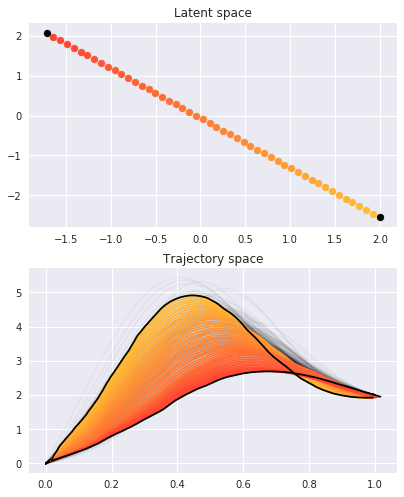

In [11]:
n_samples = 50
X_di = np.vstack((x1[np.newaxis], x2[np.newaxis]))

Z_di = model.encode(Variable(Tensor(X_di.reshape(len(X_di), -1))))[0]
Z_di = tensor_to_array(Z_di)
Z_i = np.empty((n_samples, n_latent_dims))
for i in range(n_samples):
    t = (i / (n_samples - 1))
    Z_i[i] = t * Z_di[0] + (1 - t) * Z_di[1]
X_i = tensor_to_array(model.decode(Variable(Tensor(Z_i))))

plt.figure(figsize=(textwidth, textheight), dpi=dpi)
plt.subplots_adjust(left=0.1, right=0.98)

ax = plt.subplot(211)
ax.set_title("Latent space")
plt.scatter(Z_di[:, 0], Z_di[:, 1], color="k")
for i in range(1, n_samples - 1):
    t = (i - 1) / (n_samples - 2)
    plt.scatter(Z_i[i, 0], Z_i[i, 1], color=[1, 0.75 - t / 2, 0.2])

ax = plt.subplot(212)
ax.set_title("Trajectory space")

plt.plot(X[:, 0].T, X[:, 1].T, color="k", alpha=0.03)

X_plot = X_di.reshape(len(X_di), n_task_dims, n_steps)

X_plot = X_i.reshape(len(X_i), n_task_dims, n_steps)
for i in range(1, n_samples - 1):
    t = (i - 1) / (n_samples - 2)
    ax.plot(X_plot[i, 0], X_plot[i, 1], color=[1, 0.75 - t / 2, 0.2])
ax.plot(X_plot[(1, -1), 0].T, X_plot[(1, -1), 1].T, color="k")